In [2]:
''' Comand Prompt'''

import __init__
import gp_class
import gp_functions
import mpc_class
import optimize

import pandas as pd
import numpy as np
import casadi as ca
import scipy.linalg
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle

from mpc_class import MPC
from gp_class import GP

import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn import metrics

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Data Set

In [3]:
# Data Set

df = pd.read_csv('data_measured_random_data.csv')
df.head()

,Unnamed: 0,V4,V5,V6,V7,V8,V9,I1,I2,I3,I4,I5,I6,Load1,Load2,Load3,Gen1,Gen2,Gen3,Wind1,Wind2,Solar1,Solar2
0,0,0.927585,0.892795,0.922912,0.901561,0.907819,0.942737,4.826812,1.559757,1.491426,0.555835,4.670855,3.726221,83.637404,73.280624,38.922042,120.0,-179.649266,95.0,45.104480,31.162053,25.078349,44.575339
1,1,0.915976,0.876833,0.912801,0.880001,0.888959,0.929651,4.972427,1.186117,1.691754,0.256052,5.025643,3.882505,80.066312,70.151738,37.260175,120.0,-195.780411,95.0,58.887284,38.719489,23.396309,34.837300
2,2,0.937018,0.905946,0.932281,0.917477,0.922548,0.953202,4.702279,1.561927,1.504734,0.733486,4.954366,3.626683,76.927805,67.401871,35.799619,120.0,-148.049877,95.0,34.425818,46.702309,18.864183,0.061175
3,3,0.932300,0.899848,0.929480,0.908706,0.914460,0.948021,4.610159,1.027667,1.452916,0.586922,4.700351,3.711500,75.076195,65.779545,34.937942,120.0,-172.783924,95.0,49.174016,31.112210,1.884806,38.319755
4,4,0.921280,0.884119,0.917781,0.887377,0.895115,0.934082,4.879579,1.288133,1.746052,0.323943,4.930327,3.899324,72.259865,63.311960,33.627316,120.0,-187.342371,95.0,50.603953,31.689670,20.829394,27.621705


In [5]:
def _get_x(df):
    X1 = df[['V4', 'V5', 'V6', 'V7', 'V8', 'V9']].shift(1)
    X2 = df[['Load1', 'Load2', 'Load3', 'Gen2', 'Wind1', 'Wind2', 'Solar1', 'Solar2']]
    X = pd.merge(X1, X2, left_index=True, right_index=True)
    return X.iloc[1:].iloc[:-1]


def _get_y(df):
    y = df[['V4', 'V5', 'V6', 'V7', 'V8', 'V9']]
    return y.iloc[1:].iloc[:-1]


X = _get_x(df)
Y = _get_y(df)
Y

,V4,V5,V6,V7,V8,V9
1,0.915976,0.876833,0.912801,0.880001,0.888959,0.929651
2,0.937018,0.905946,0.932281,0.917477,0.922548,0.953202
3,0.932300,0.899848,0.929480,0.908706,0.914460,0.948021
4,0.921280,0.884119,0.917781,0.887377,0.895115,0.934082
5,0.906964,0.865138,0.903817,0.861714,0.872906,0.918581
...,...,...,...,...,...,...
714,0.946266,0.918362,0.942399,0.942039,0.943731,0.967496
715,0.946343,0.919108,0.941058,0.942585,0.944158,0.967586
716,0.941780,0.913019,0.938316,0.934034,0.936811,0.962931
717,0.941937,0.912119,0.937654,0.932703,0.934908,0.961344


In [86]:
Nx = Y.shape[1]
Nu = 4
Nd = 4

n_train = 200
n_test = n_train + 100

X_train = X.iloc[:n_train] #168 
Y_train = Y.iloc[:n_train]
X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy()


X_test = X.iloc[n_train:n_test]
Y_test = Y.iloc[n_train:n_test]

X_d = X.iloc[n_train:n_test, Nx+Nu:Nx+Nu+Nd]

X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy()
X_d = X_d.to_numpy()

x0 = Y_train[-1]
u0 = X_train[-1, Nx:Nx+Nu]

# 1. TA

# GP

In [87]:
""" Time Sampling """
dt = 1


""" Options for hyper-parameter optimization """
solver_opts = {}
#solver_opts['ipopt.linear_solver'] = 'ma27' # Faster plugin solver than default
solver_opts['expand']= False                # Choise between SX or MX graph


print('*****************')
print('GP')
print('*****************')
gp = GP(X_train, Y_train, dt, mean_func='zero', optimizer_opts=solver_opts, gp_method='TA', 
        normalize=True, multistart=1)

print('*****************')
print('Hyper_parameters')
print('*****************')
gp.print_hyper_parameters()

print('*****************')
print('Validation')
print('*****************')
MSE, SMSE, MNLP = gp.validate(X_test, Y_test)
print('MSE:', MSE)
print('SMSE:', SMSE)
print('MNLP:', MNLP)

size = gp.get_size()
print('size:',size)

*****************
GP
*****************

________________________________________
# Optimizing hyperparameters (N=200)
----------------------------------------


C:\Users\MILE\Desktop\MPCGP Los.Alam - finished project\MPC_GP\optimize.py:467: OptimizeWarning: Unknown solver options: expand
  method='SLSQP', options=options, bounds=bounds, tol=1e-12)


K is not positive definit, adding jitter!
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -902.2853128082199
            Iterations: 105
            Function evaluations: 2471
            Gradient evaluations: 104
* State 0:  34.202489 s
K is not positive definit, adding jitter!
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -914.1515126486003
            Iterations: 78
            Function evaluations: 1888
            Gradient evaluations: 78
* State 1:  26.471105 s
K is not positive definit, adding jitter!
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -861.3989608029367
            Iterations: 164
            Function evaluations: 3440
            Gradient evaluations: 164
* State 2:  47.270771 s
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -937.5235246101622
            Iterations: 127
            Function 

# MPC

In [88]:
""" Limits in the MPC problem """
#ulb = [0.,    0.,  0.,   -150.]
#uub = [133., 116., 62.,   50.]
#xlb = [4,   0.5,   0.05,   0.1,     3.2]
#xub = [5.2,    2,     2,     1.7,     5.2]


ulb = [df['Load1'].min(), df['Load2'].min(), df['Load3'].min(), df['Gen2'].min()]
uub = [df['Load1'].max(), df['Load2'].max(), df['Load3'].max(), df['Gen2'].max()]
#xlb = [df['I1'].min(), df['I2'].min(), df['I3'].min(), df['I4'].min(), df['I5'].min(), df['I6'].min(), df['V4'].min()]
#xub = [df['I1'].max(), df['I2'].max(), df['I3'].max(), df['I4'].max(), df['I5'].max(), df['I6'].max(), df['V4'].max()]

xlb = [df['V4'].min()-0.03, df['V5'].min()-0.03, df['V6'].min()-0.03, df['V7'].min()-0.03, df['V8'].min()-0.03, df['V9'].min()-0.03]
xub = [df['V4'].max()+0.03, df['V5'].max()+0.03, df['V6'].max()+0.03, df['V7'].max()+0.03, df['V8'].max()+0.03, df['V9'].max()+0.03]



""" Initial state, input and set point  """
#x_sp = np.array([4.5, 1.2, 1, 1.2, 4.2])

x_sp = np.array([df['V4'].mean(), df['V5'].mean(), df['V6'].mean(), df['V7'].mean(), df['V8'].mean(), df['V9'].mean()])
x0 = x0
u0 = u0


""" Penalty matrices """
#Q = np.diag([10, 10])  
#R = np.diag([1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3])
#S = np.diag([1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2])

""" Options to pass to the MPC solver """
solver_opts = {
            #'ipopt.linear_solver' : 'ma27',    # Plugin solver from HSL
            'ipopt.max_cpu_time' : 100,
            'expand' : True,
            'ipopt.expect_infeasible_problem' : 'yes'
}




""" Build MPC solver """
mpc = MPC(horizon=5*dt, Xd=X_d, gp=gp,
           gp_method='TA',
           ulb=ulb, uub=uub, xlb=xlb, xub=xub, Q=None, R=None, S=None,
           terminal_constraint=None, costFunc='quad', feedback=False,
           solver_opts=solver_opts, discrete_method='gp'
           )


________________________________________
# Time to build mpc solver: 155.338020 sec
# Number of variables: 236
# Number of equality constraints: 162
# Number of inequality constraints: 100
----------------------------------------



Solving MPC with 5 step horizon
* t=0.000000: Maximum_CpuTime_Exceeded - 100.394855 sec
* t=1.000000: Solved_To_Acceptable_Level - 42.125993 sec
* t=2.000000: Solve_Succeeded - 15.210306 sec
* t=3.000000: Solve_Succeeded - 11.623371 sec
* t=4.000000: Solve_Succeeded - 2.103796 sec
* t=5.000000: Solve_Succeeded - 2.743432 sec
* t=6.000000: Solve_Succeeded - 4.200586 sec
* t=7.000000: Solve_Succeeded - 16.283709 sec
* t=8.000000: Solve_Succeeded - 8.344241 sec
* t=9.000000: Solve_Succeeded - 12.902644 sec
* t=10.000000: Solve_Succeeded - 8.227289 sec
* t=11.000000: Solve_Succeeded - 1.930917 sec
* t=12.000000: Solve_Succeeded - 5.330959 sec
* t=13.000000: Solve_Succeeded - 3.799832 sec
* t=14.000000: Solve_Succeeded - 17.164208 sec
* t=15.000000: Solve_Succeeded - 6.080544 sec
* t=16.000000: Solve_Succeeded - 15.285279 sec
* t=17.000000: Solve_Succeeded - 10.057264 sec
* t=18.000000: Solve_Succeeded - 6.287417 sec
* t=19.000000: Solve_Succeeded - 4.106655 sec


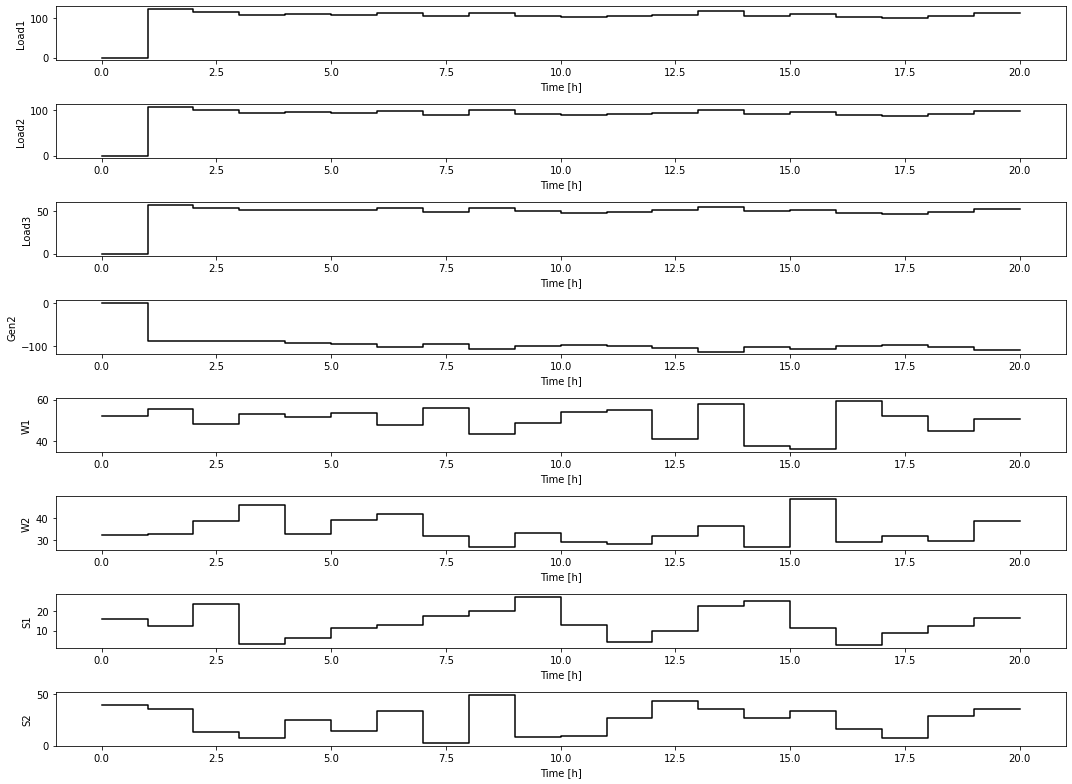

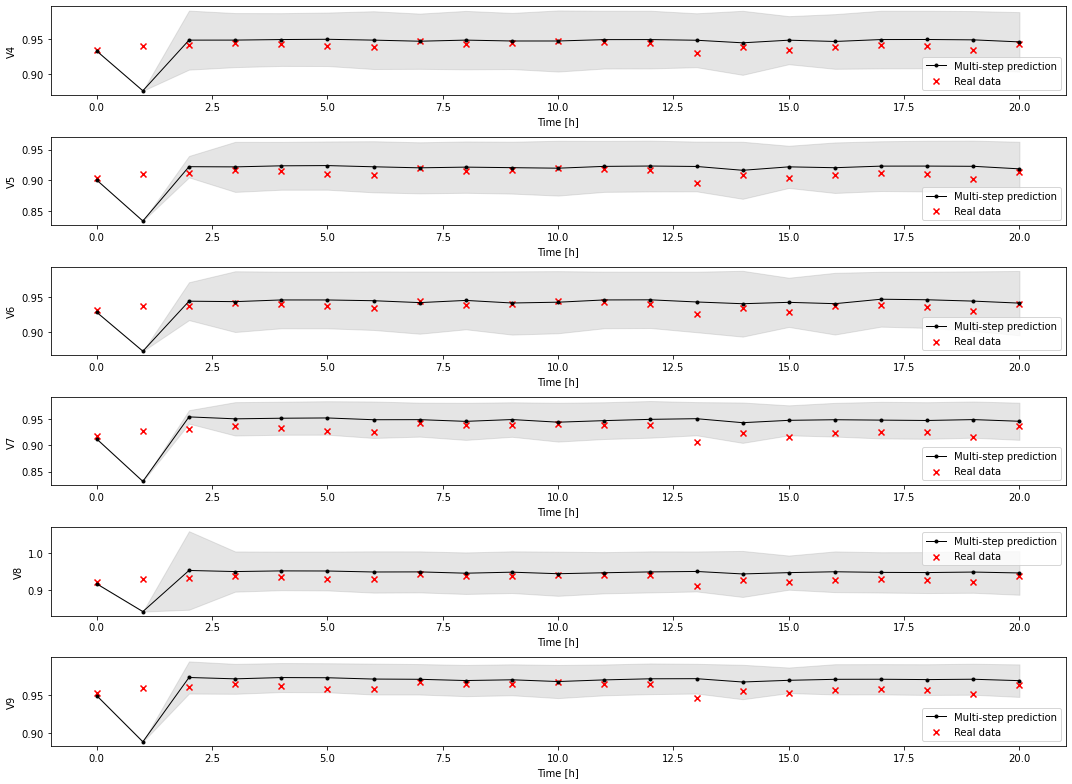

(<Figure size 1080x792 with 6 Axes>, <Figure size 1080x792 with 8 Axes>)

In [90]:
x_pred_var, u= mpc.solve_1(x0, u0=u0, sim_time=20*dt, x_sp=x_sp, debug=False)
mpc.plot_1(Y_test = Y_test, xnames=['V4', 'V5', 'V6', 'V7', 'V8', 'V9'],
         unames=['Load1', 'Load2', 'Load3', 'Gen2', 'W1', 'W2', 'S1', 'S2'])

# 2. ME

# GP

In [91]:
""" Time Sampling """
dt = 1


""" Options for hyper-parameter optimization """
solver_opts = {}
#solver_opts['ipopt.linear_solver'] = 'ma27' # Faster plugin solver than default
solver_opts['expand']= False                # Choise between SX or MX graph


print('*****************')
print('GP')
print('*****************')
gp = GP(X_train, Y_train, dt, mean_func='zero', optimizer_opts=solver_opts, gp_method='ME', 
        normalize=True, multistart=1)

print('*****************')
print('Hyper_parameters')
print('*****************')
gp.print_hyper_parameters()

print('*****************')
print('Validation')
print('*****************')
MSE, SMSE, MNLP = gp.validate(X_test, Y_test)
print('MSE:', MSE)
print('SMSE:', SMSE)
print('MNLP:', MNLP)

size = gp.get_size()
print('size:',size)

*****************
GP
*****************

________________________________________
# Optimizing hyperparameters (N=200)
----------------------------------------


C:\Users\MILE\Desktop\MPCGP Los.Alam - finished project\MPC_GP\optimize.py:467: OptimizeWarning: Unknown solver options: expand
  method='SLSQP', options=options, bounds=bounds, tol=1e-12)


K is not positive definit, adding jitter!
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -902.2853128082199
            Iterations: 105
            Function evaluations: 2471
            Gradient evaluations: 104
* State 0:  24.348179 s
K is not positive definit, adding jitter!
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -914.1515126486003
            Iterations: 78
            Function evaluations: 1888
            Gradient evaluations: 78
* State 1:  18.233224 s
K is not positive definit, adding jitter!
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -861.3989608029367
            Iterations: 164
            Function evaluations: 3440
            Gradient evaluations: 164
* State 2:  33.113055 s
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -937.5235246101622
            Iterations: 127
            Function 

# MPC

In [92]:
""" Limits in the MPC problem """
#ulb = [0.,    0.,  0.,   -150.]
#uub = [133., 116., 62.,   50.]
#xlb = [4,   0.5,   0.05,   0.1,     3.2]
#xub = [5.2,    2,     2,     1.7,     5.2]


ulb = [df['Load1'].min(), df['Load2'].min(), df['Load3'].min(), df['Gen2'].min()]
uub = [df['Load1'].max(), df['Load2'].max(), df['Load3'].max(), df['Gen2'].max()]
#xlb = [df['I1'].min(), df['I2'].min(), df['I3'].min(), df['I4'].min(), df['I5'].min(), df['I6'].min(), df['V4'].min()]
#xub = [df['I1'].max(), df['I2'].max(), df['I3'].max(), df['I4'].max(), df['I5'].max(), df['I6'].max(), df['V4'].max()]

xlb = [df['V4'].min()-0.03, df['V5'].min()-0.03, df['V6'].min()-0.03, df['V7'].min()-0.03, df['V8'].min()-0.03, df['V9'].min()-0.03]
xub = [df['V4'].max()+0.03, df['V5'].max()+0.03, df['V6'].max()+0.03, df['V7'].max()+0.03, df['V8'].max()+0.03, df['V9'].max()+0.03]



""" Initial state, input and set point  """
#x_sp = np.array([4.5, 1.2, 1, 1.2, 4.2])

x_sp = np.array([df['V4'].mean(), df['V5'].mean(), df['V6'].mean(), df['V7'].mean(), df['V8'].mean(), df['V9'].mean()])
x0 = x0
u0 = u0


""" Penalty matrices """
#Q = np.diag([10, 10])  
#R = np.diag([1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3])
#S = np.diag([1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2])

""" Options to pass to the MPC solver """
solver_opts = {
            #'ipopt.linear_solver' : 'ma27',    # Plugin solver from HSL
            'ipopt.max_cpu_time' : 250,
            'expand' : True,
            'ipopt.expect_infeasible_problem' : 'yes'
}




""" Build MPC solver """
mpc = MPC(horizon=5*dt, Xd=X_d, gp=gp,
           gp_method='ME',
           ulb=ulb, uub=uub, xlb=xlb, xub=xub, Q=None, R=None, S=None,
           terminal_constraint=None, costFunc='quad', feedback=False,
           solver_opts=solver_opts, discrete_method='gp'
           )


________________________________________
# Time to build mpc solver: 47.423930 sec
# Number of variables: 236
# Number of equality constraints: 162
# Number of inequality constraints: 100
----------------------------------------



Solving MPC with 5 step horizon
* t=0.000000: Solve_Succeeded - 15.644275 sec
* t=1.000000: Solve_Succeeded - 0.604387 sec
* t=2.000000: Solve_Succeeded - 3.188178 sec
* t=3.000000: Solve_Succeeded - 3.388053 sec
* t=4.000000: Solve_Succeeded - 0.722586 sec
* t=5.000000: Solve_Succeeded - 0.476730 sec
* t=6.000000: Solve_Succeeded - 1.916193 sec
* t=7.000000: Solve_Succeeded - 6.799124 sec
* t=8.000000: Solve_Succeeded - 2.199096 sec
* t=9.000000: Solve_Succeeded - 4.507429 sec
* t=10.000000: Solve_Succeeded - 2.542550 sec
* t=11.000000: Solve_Succeeded - 0.718610 sec
* t=12.000000: Solve_Succeeded - 2.642992 sec
* t=13.000000: Solve_Succeeded - 1.377214 sec
* t=14.000000: Solve_Succeeded - 4.404489 sec
* t=15.000000: Solve_Succeeded - 1.994860 sec
* t=16.000000: Solve_Succeeded - 5.103109 sec
* t=17.000000: Solve_Succeeded - 2.498570 sec
* t=18.000000: Solve_Succeeded - 1.737992 sec
* t=19.000000: Solve_Succeeded - 1.366223 sec


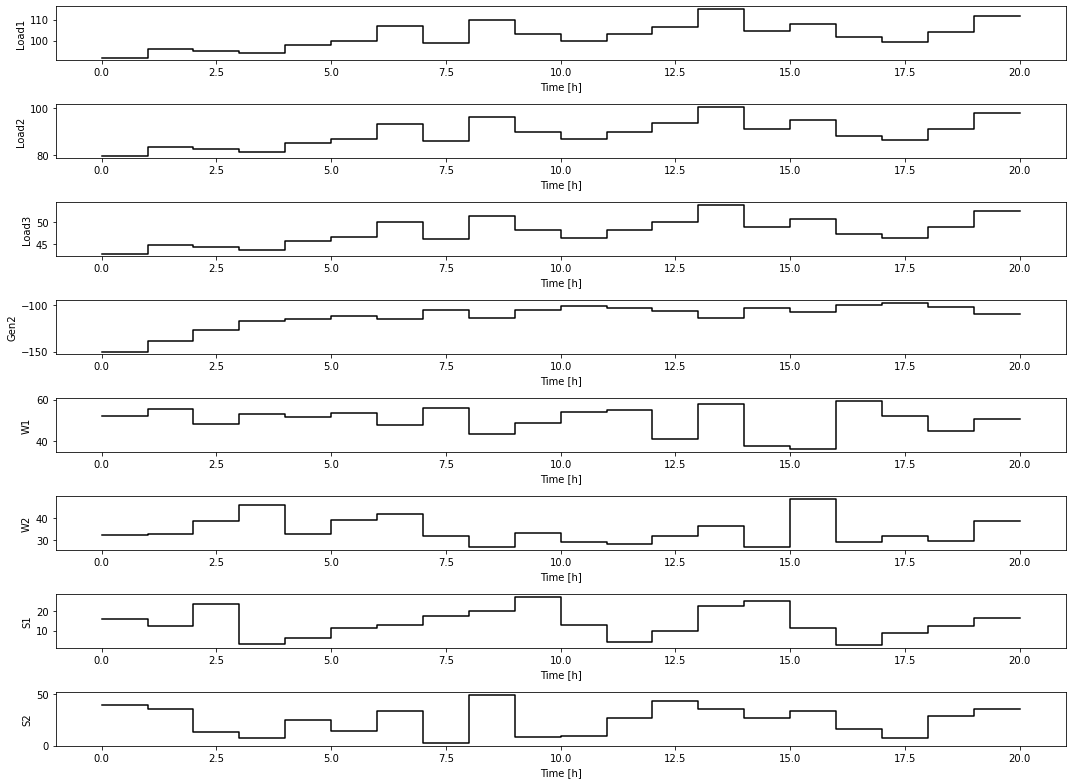

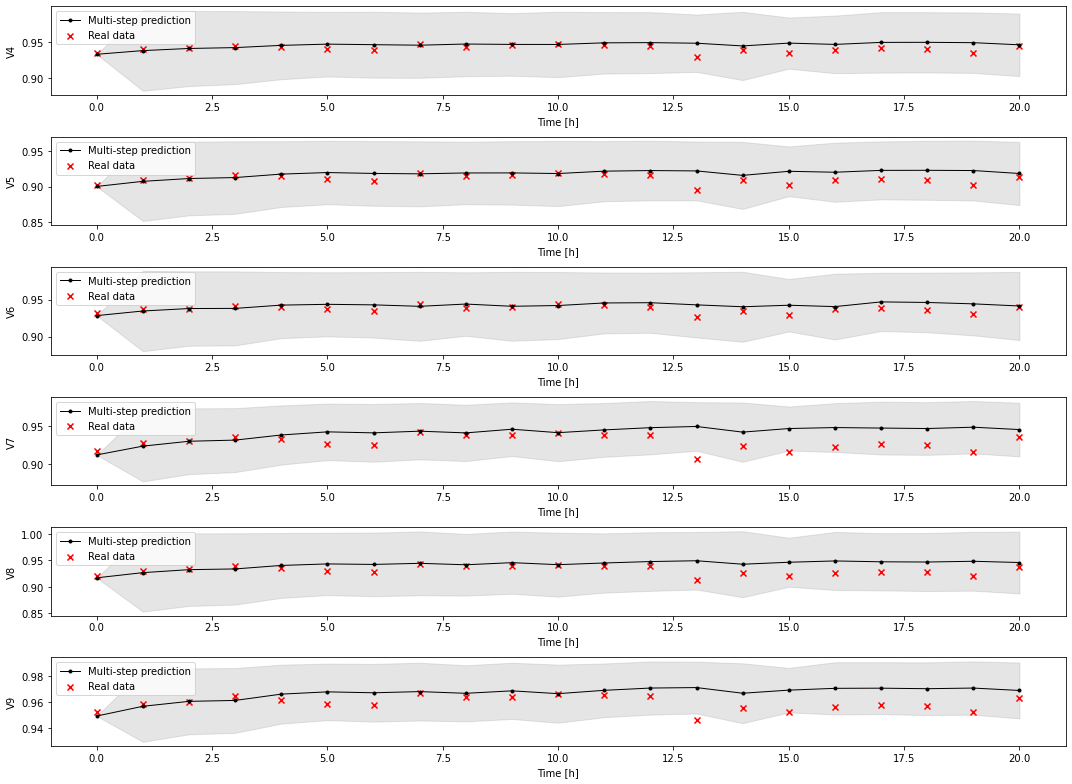

(<Figure size 1080x792 with 6 Axes>, <Figure size 1080x792 with 8 Axes>)

In [93]:
x_pred_var, u= mpc.solve_1(x0, u0=u0, sim_time=20*dt, x_sp=x_sp, debug=False)
mpc.plot_1(Y_test = Y_test, xnames=['V4', 'V5', 'V6', 'V7', 'V8', 'V9'],
         unames=['Load1', 'Load2', 'Load3', 'Gen2', 'W1', 'W2', 'S1', 'S2'])